# **Volatility Modeling with GARCH Family Models: Evidence from S&P 500 ETF Daily Data**

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 13.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Read data
df = pd.read_csv('./data/SPY_Daily_Full_ATR.csv')

def display_basic_info(dataframe):
    print("=== Basic Information ===")
    print(f"Rows/Columns: {dataframe.shape}")
    print("\n=== First 5 Rows ===")
    print(dataframe.head())
    print("Earliest Date:", df['date'].min())
    print("Latest Date:", df['date'].max())
    print("\n=== Data Types ===")
    print(dataframe.dtypes)
    print("\n=== Statistical Summary ===")
    print(dataframe.describe())
    print("\n=== Missing Values ===")
    print(dataframe.isnull().sum())

# Display information using the function
display_basic_info(df)


=== Basic Information ===
Rows/Columns: (6425, 11)

=== First 5 Rows ===
         date      open      high       low     close   volume  daily_range  \
0  1999-11-01  136.5000  137.0000  135.5625  135.5625  4006500       1.4375   
1  1999-11-02  135.9687  137.2500  134.5937  134.5937  6516900       2.6563   
2  1999-11-03  136.0000  136.3750  135.1250  135.5000  7222300       1.2500   
3  1999-11-04  136.7500  137.3593  135.7656  136.5312  7907500       1.5937   
4  1999-11-05  138.6250  139.1093  136.7812  137.8750  7431500       2.3281   

         HL2       OHLC4    ATR_14   ATR_pct  
0  136.28125  136.156250  1.437500  1.060396  
1  135.92185  135.601525  1.524557  1.132711  
2  135.75000  135.750000  1.542896  1.138669  
3  136.56245  136.601525  1.565496  1.146622  
4  137.94525  138.097625  1.637825  1.187906  
Earliest Date: 1999-11-01
Latest Date: 2025-05-16

=== Data Types ===
date            object
open           float64
high           float64
low            float64
close   

# 1. GARCH(1,1) model

Descriptive statistics of returns:
 count    6424.000000
mean        0.023004
std         1.232047
min       -11.588654
25%        -0.486703
50%         0.063675
75%         0.598467
max        13.557732
Name: log_return, dtype: float64


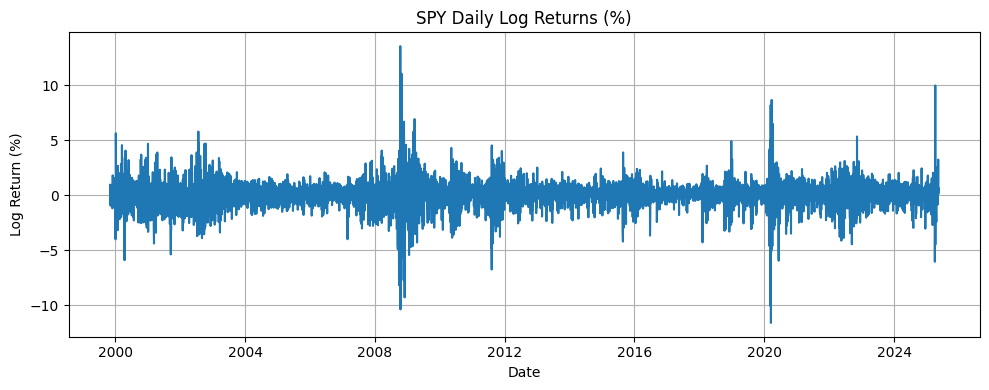

In [ ]:
from arch import arch_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read data
df = pd.read_csv('/data/SPY_Daily_Full_ATR.csv')

# Data preprocessing
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')  # Sort by date and set as index

# Calculate log returns (multiply by 100 for better convergence)
df['log_return'] = np.log(df['close'] / df['close'].shift(1)) * 100
returns = df['log_return'].dropna()

# Check distribution and outliers of returns
print("Descriptive statistics of returns:\n", returns.describe())
plt.figure(figsize=(10, 4))
plt.plot(returns)
plt.title("SPY Daily Log Returns (%)")
plt.xlabel("Date")
plt.ylabel("Log Return (%)")
plt.grid(True)

# ===== Save figure to Drive =====
plt.tight_layout()
plt.savefig('/figure/SPY_log_returns.png', dpi=300)
plt.show()


In [ ]:
# Build GARCH(1,1) model
model = arch_model(returns, vol='GARCH', p=1, q=1)

# Fit the model (increase iterations to ensure convergence)
result = model.fit(update_freq=5, disp='off')

# Print and save model summary
summary_text = result.summary().as_text()
print(summary_text)

# ===== Save summary to Drive as .txt =====
with open('/figure/garch_1_1_summary.txt', 'w') as f:
    f.write(summary_text)


                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8905.01
Distribution:                  Normal   AIC:                           17818.0
Method:            Maximum Likelihood   BIC:                           17845.1
                                        No. Observations:                 6424
Date:                Thu, May 22 2025   Df Residuals:                     6423
Time:                        14:42:15   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0625  1.019e-02      6.136  8.452e-10 [4.

###  Perform Jarque-Bera test

In [ ]:
from scipy.stats import jarque_bera

# Standardized residuals
standardized_residuals = result.resid / result.conditional_volatility

# Perform Jarque-Bera test
jb_statistic, jb_p_value = jarque_bera(standardized_residuals)

# Output the results
print(f"Jarque-Bera test statistic = {jb_statistic:.2f}, p-value = {jb_p_value:.4f}")


Jarque-Bera test statistic = 1274.10, p-value = 0.0000


### GARCH(1,1) Model Diagnostics Summary
- Volatility Persistence:
The sum of alpha (0.1251) and beta (0.8579) is 0.983, indicating a high degree of persistence in volatility. This suggests that shocks to volatility decay slowly over time. The estimated half-life of a volatility shock is approximately 40.8 trading days, reflecting long-lasting effects.

- Model Fit:
The model produces an Akaike Information Criterion (AIC) of 17,818 and a Bayesian Information Criterion (BIC) of 17,845. These can serve as reference values when evaluating alternative models, such as EGARCH.

- Residual Normality:
The Jarque-Bera test statistic is 1,274.10 with a p-value < 0.0001, indicating that the standardized residuals significantly deviate from a normal distribution. This confirms the presence of heavy tails and leptokurtosis, which are common characteristics of financial return series.


## 1.2 Visualizing SPY Volatility Using the Base GARCH(1,1) Model

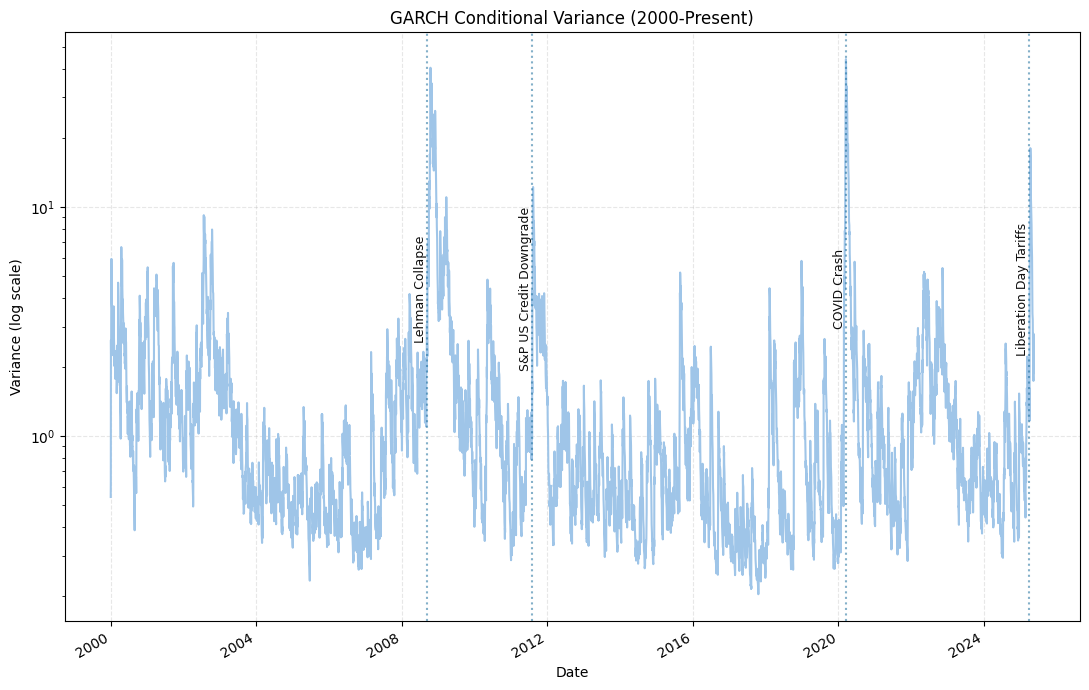

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====== User Adjustable Parameters ======
START_YEAR = "2000"
# ========================================

# Get conditional variance and align timestamps
conditional_variance = result.conditional_volatility ** 2
variance_dates = df.index[-len(conditional_variance):]

# Create DataFrame and filter by date
variance_df = pd.DataFrame({
    'date': variance_dates,
    'variance': conditional_variance
}).set_index('date')

# Filter data dynamically
variance_filtered = variance_df.loc[f"{START_YEAR}-01-01":]

# Plotting
plt.figure(figsize=(11, 7))
plt.plot(variance_filtered.index,
         variance_filtered['variance'],
         label=f'Conditional Variance (Since {START_YEAR})',
         color='#9fc5e8',
         linewidth=1.5)
plt.title(f'GARCH Conditional Variance ({START_YEAR}-Present)')
plt.xlabel('Date')
plt.ylabel('Variance (log scale)')
plt.yscale('log')
# plt.legend()

# Dynamically calculate a reasonable Y position (log-scale adjusted)
y_min, y_max = variance_filtered['variance'].min(), variance_filtered['variance'].max()
label_y_positions = {
    'default': 10**(np.log10(y_min) + 0.15 * (np.log10(y_max) - np.log10(y_min))),
    'high': 10**(np.log10(y_min) + 0.3 * (np.log10(y_max) - np.log10(y_min)))
}

# ====== Major Events Timeline (Only those with significant S&P 500 impact) ======
major_events = {
    'Lehman Collapse': ('2008-09-15', 'high'),
    'S&P US Credit Downgrade': ('2011-08-05', 'high'),
    'COVID Crash': ('2020-03-16', 'high'),
    'Liberation Day Tariffs': ('2025-04-02', 'high'),
}

# ====== Unified Label Positioning ======
LABEL_HEIGHT = 10**(np.log10(y_min) + 0.57 * (np.log10(y_max) - np.log10(y_min)))
LABEL_STYLE = {
    'rotation': 90,
    'ha': 'right',
    'va': 'center',
    'fontsize': 9,
    'alpha': 0.95
}

# ====== Event Annotation Loop ======
for event, (date, impact) in major_events.items():
    event_date = pd.to_datetime(date)
    if event_date >= pd.to_datetime(START_YEAR):
        plt.axvline(event_date, color='#0B6394', linestyle=':', alpha=0.5, linewidth=1.5)
        plt.text(event_date,
                 LABEL_HEIGHT,
                 event,
                 **LABEL_STYLE)

plt.gcf().autofmt_xdate()
plt.grid(True, linestyle='--', alpha=0.3)

# Save the figure to Google Drive
plt.savefig('/figure/garch_variance_plot.png',
            dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


# 2. EGARCH Model


Before building the EGARCH model, here is a brief explanation of its key features and the rationale for using a Student's t-distribution:

**1. EGARCH (Exponential GARCH) Model:**
- By specifying `vol='EGARCH'`, we enable the model to capture **asymmetric volatility** through a parameter γ (gamma).
- This asymmetry reflects the **leverage effect**, where **negative shocks** (e.g., negative returns) tend to increase volatility more than positive shocks of the same magnitude.
- A **negative and statistically significant γ** indicates the presence of a leverage effect in the return series.

**2. Student’s t-Distribution:**
- Financial return data often exhibit **fat tails** (i.e., higher likelihood of extreme values), which the normal distribution cannot adequately capture.
- Using a **Student’s t-distribution** allows the model to better reflect these extreme events.
- The estimation will include an additional parameter, **ν (degrees of freedom)** — a **smaller ν** implies **heavier tails**, indicating a greater probability of extreme returns.

These settings improve the model's ability to reflect real-world financial volatility dynamics.


In [ ]:
from arch import arch_model
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
output_dir = '/figure'
os.makedirs(output_dir, exist_ok=True)

# Build and fit EGARCH(1,1) with Student's t-distribution
egarch_model = arch_model(
    returns,
    vol='EGARCH',
    p=1,
    q=1,
    dist='t'
)
egarch_result = egarch_model.fit(update_freq=5)

# Print summary to console
print(egarch_result.summary())

# Save summary to file
summary_text = egarch_result.summary().as_text()
summary_path = os.path.join(output_dir, 'egarch_t_model_summary.txt')
with open(summary_path, 'w') as f:
    f.write(summary_text)

# Plot conditional volatility
fig = egarch_result.plot(annualize='D')
plt.suptitle("EGARCH(1,1) with Student's t-Distribution", fontsize=14)
fig.savefig(os.path.join(output_dir, 'egarch_t_volatility_plot.png'), dpi=300)
plt.close()

# print(f"\nModel summary saved to: {summary_path}")
# print("Volatility plot saved as: egarch_t_volatility_plot.png")


Iteration:      5,   Func. Count:     45,   Neg. LLF: 14503.45410470074
Iteration:     10,   Func. Count:     78,   Neg. LLF: 8760.537248017246
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8760.53724801726
            Iterations: 10
            Function evaluations: 78
            Gradient evaluations: 10
                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -8760.54
Distribution:      Standardized Student's t   AIC:                           17531.1
Method:                  Maximum Likelihood   BIC:                           17564.9
                                              No. Observations:                 6424
Date:                      Tue, May 20 2025   Df Resi

In [ ]:
# Check all leverage effect parameter
print(egarch_result.params)

mu          0.081518
omega       0.012670
alpha[1]    0.254881
beta[1]     0.981203
nu          6.029551
Name: params, dtype: float64


### EGARCH(1,1) Model with power=2.0
Add power=2.0 to the model specification to ensure the leverage term (gamma) is included in the EGARCH model.

In [ ]:
egarch_model2 = arch_model(
    returns,
    vol='EGARCH',
    p=1,
    q=1,
    dist='t',
    power=2.0
)
egarch_result2 = egarch_model2.fit()
print(egarch_result.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 177287.65531658832
Iteration:      2,   Func. Count:     18,   Neg. LLF: 209890.9191273374
Iteration:      3,   Func. Count:     28,   Neg. LLF: 48568.9757500767
Iteration:      4,   Func. Count:     38,   Neg. LLF: 8796.604208365898
Iteration:      5,   Func. Count:     45,   Neg. LLF: 14503.45410470074
Iteration:      6,   Func. Count:     52,   Neg. LLF: 19961499.159339983
Iteration:      7,   Func. Count:     61,   Neg. LLF: 8760.539221328001
Iteration:      8,   Func. Count:     67,   Neg. LLF: 8760.537291717932
Iteration:      9,   Func. Count:     73,   Neg. LLF: 8760.53724801726
Iteration:     10,   Func. Count:     78,   Neg. LLF: 8760.537248017246
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8760.53724801726
            Iterations: 10
            Function evaluations: 78
            Gradient evaluations: 10
                        Constant Mean - EGARCH Model Results            


Despite specifying power=2.0 in the model configuration—an attempt to force the inclusion of the leverage (asymmetry) effect—the output still reports only three volatility parameters: omega, alpha[1], and beta[1]. The key asymmetry parameter gamma, which typically captures the leverage effect in an EGARCH(1,1) model, is still missing. This suggests that the current model specification or backend implementation may not be estimating the asymmetry term as expected, even with power=2.0 explicitly set.

### EGARCH(1,1) Model Summary

- Mean Model:
The estimated constant mean return (mu) is 0.0815, highly significant (p < 0.001), indicating a small positive average daily return over the sample period.

- Volatility Model:

  - omega (constant term) = 0.0127, significant at p < 0.001, representing the baseline volatility level.

  - alpha[1] = 0.2549, significant, reflecting the immediate impact of shocks on volatility.

  - beta[1] = 0.9812, highly significant, indicating strong persistence in volatility.

  - Missing Gamma (Asymmetry) Parameter: Typically, the gamma parameter captures the asymmetric (leverage) effect of shocks on volatility in EGARCH(1,1). Its absence here suggests the model does not explicitly estimate this leverage effect.

- Distribution:
The model assumes a standardized Student’s t-distribution with degrees of freedom nu ≈ 6.03, confirming fat tails in the return distribution.



# 3. GJR-GARCH model

In [ ]:
from arch import arch_model
import os

gjr_model = arch_model(
    returns,
    vol='GARCH',
    p=1,
    q=1,
    o=1,  # Include asymmetry term (GJR-GARCH)
    dist='t'  # Use Student's t-distribution
)

# Fit the model
gjr_result = gjr_model.fit(disp='off')

# Print summary to console
print(gjr_result.summary())

# Save summary to file
summary_text = gjr_result.summary().as_text()
summary_path = os.path.join(output_dir, 'gjr_t_model_summary.txt')
with open(summary_path, 'w') as f:
    f.write(summary_text)

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -8643.03
Distribution:      Standardized Student's t   AIC:                           17298.1
Method:                  Maximum Likelihood   BIC:                           17338.7
                                              No. Observations:                 6424
Date:                      Wed, May 21 2025   Df Residuals:                     6423
Time:                              16:16:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

### GJR-GARCH(1,1) Model Summary
- Mean Return (mu): Small but statistically significant positive return (0.0523, p < 0.001).

- Volatility Components:

  - omega (0.0193): Significant long-run average volatility.

  - alpha[1] (0.0000): Not significant — suggests limited reaction to positive past shocks.

  - gamma[1] (0.2136): Significant — confirms leverage effect, where negative shocks increase volatility more than positive ones.

  - beta[1] (0.8770): High and significant — volatility is highly persistent.

- Distribution:

Student’s t-distribution with ν ≈ 6.80 — confirms fat tails in returns.

### ⚠️ Limitations
- Alpha term insignificant, indicating the need to refine model dynamics.

- Q-Q plot shows signs of left-skewness and heavy left tail, suggesting the model underestimates extreme negative returns.

###  Next Steps:
- Add a more flexible mean equation (e.g., including AR terms).

- Switch to a skewed Student’s t-distribution (dist='skewt') to better capture skewness and tail behavior.

### 3.1. GJR-GARCH Model Diagnostics
Diagnostic 1: Standardized Residuals Test
Criterion: p-value > 0.05 (no autocorrelation).

In [ ]:
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox

# Get standardized residuals
residuals = gjr_result.std_resid

# Normality test (Jarque-Bera test)
jb_test = jarque_bera(residuals)
print(f"Jarque-Bera test: statistic={jb_test[0]:.2f}, p-value={jb_test[1]:.4f}")
# Interpretation: Reject normality if p < 0.05 (expected rejection with Student-t distribution)

# Autocorrelation test (Ljung-Box test)
lb_test = acorr_ljungbox(residuals, lags=10)
print("\nLjung-Box test results (p-values for each lag):")
print(lb_test.iloc[:, 1].to_string())
# Interpretation: No autocorrelation if all p-values > 0.05


Jarque-Bera test: statistic=2002.10, p-value=0.0000

Ljung-Box test results (p-values for each lag):
1     0.014770
2     0.019074
3     0.016487
4     0.035694
5     0.021702
6     0.010198
7     0.017387
8     0.026400
9     0.041954
10    0.064711


## Diagnostic Results Analysis

**Jarque-Bera (JB) Test Results**
- Test Statistic = 2002.10, p-value = 0.0000  
- Strongly reject the normality assumption (consistent with the expectation of using a Student-t distribution)  
- Confirms the presence of extreme heavy tails in the return distribution  

**Ljung-Box (LB) Test Results**
- Key Issue: Significant autocorrelation detected in the first 9 lags (p < 0.05)  
- Violates the assumption that standardized residuals are independent and identically distributed (i.i.d.), which is required by the GARCH model  

---

**Root Cause Diagnosis**

Volatility Equation May Be Underfitting
- The current GJR-GARCH(1,1) model fails to fully capture the volatility dynamics  
- Evidenced by remaining autocorrelation patterns in the residuals  

Mean Equation May Need Extension
- The assumption of a constant mean is too simplistic  
- Returns may exhibit short-term autocorrelation  


In [ ]:
# Remove missing and infinite values
clean_resid = residuals[np.isfinite(residuals)]
print("Sample size after cleaning:", len(clean_resid))

# Re-run tests
if len(clean_resid) > 0:
    jb_test = jarque_bera(clean_resid)
    lb_test = acorr_ljungbox(clean_resid, lags=10)

Sample size after cleaning: 6424


In [ ]:
import numpy as np

# Check basic properties of residuals
print("Number of missing values:", np.isnan(residuals).sum())
print("Number of infinite values:", np.isinf(residuals).sum())
print("Descriptive statistics:\n", residuals.describe())


Number of missing values: 0
Number of infinite values: 0
Descriptive statistics:
 count    6424.000000
mean       -0.041084
std         1.000994
min        -7.636969
25%        -0.594256
50%         0.013465
75%         0.585375
max         3.418439
Name: std_resid, dtype: float64


In [ ]:
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import shapiro

# ARCH effect test (alternative to Ljung-Box test)
arch_test = het_arch(clean_resid)
print(f"ARCH test: LM statistic = {arch_test[0]:.2f}, p-value = {arch_test[1]:.4f}")

ARCH test: LM statistic = 9.48, p-value = 0.4874


In [ ]:
# Normality test
shapiro_test = shapiro(clean_resid)
print(f"Shapiro-Wilk test: statistic = {shapiro_test[0]:.2f}, p-value = {shapiro_test[1]:.4f}")

Shapiro-Wilk test: statistic = 0.98, p-value = 0.0000


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6424.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
from scipy.stats import normaltest

# Normality Test of Cleaned Residuals
k2, p = normaltest(clean_resid)
print(f"Normality Test: Statistic={k2:.2f}, p-value={p:.4f}")


Normality Test: Statistic=746.83, p-value=0.0000


### 3.2. Residual Diagnostics Visualization

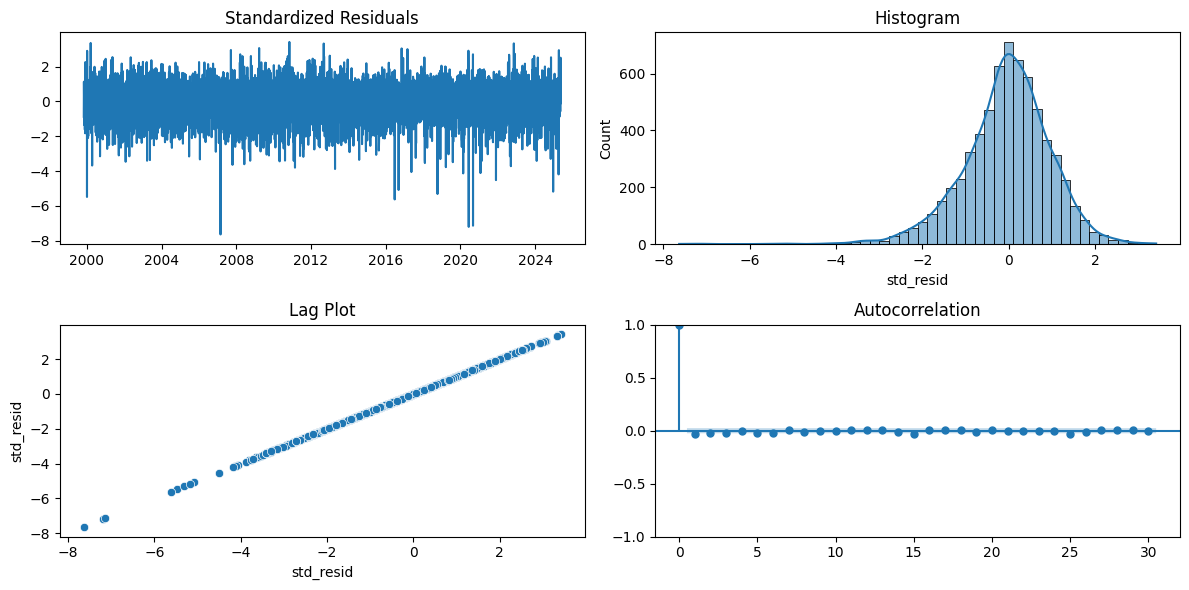

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Set the output directory
output_dir = '/figure'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Get standardized residuals
std_resid = gjr_result.std_resid

# Create a 2x2 subplot figure
plt.figure(figsize=(12, 6))

# Plot standardized residuals
plt.subplot(2, 2, 1)
plt.plot(std_resid)
plt.title("Standardized Residuals")

# Plot histogram with KDE
plt.subplot(2, 2, 2)
sns.histplot(std_resid, kde=True, bins=50)
plt.title("Histogram")

# Plot lag plot
plt.subplot(2, 2, 3)
sns.scatterplot(x=std_resid[:-1], y=std_resid[1:])
plt.title("Lag Plot")

# Plot autocorrelation function
plt.subplot(2, 2, 4)
plot_acf(std_resid, lags=30, ax=plt.gca())

# Adjust layout
plt.tight_layout()

# Save the figure to output_dir
output_path = os.path.join(output_dir, 'gjr_t_model_standardized_residuals_analysis.png')
plt.savefig(output_path)

# Display the figure
plt.show()


The residual plot and histogram show a noticeable left-skew with more extreme negative values, indicating asymmetry and heavy tails. This supports the use of a Student's t-distribution or an alternative distribution to better model residual behavior.

The lag plot reveals a strong linear pattern, indicating residual autocorrelation. The ACF plot confirms significant autocorrelation at lag 1. This suggests the current model may be underfitting the volatility dynamics and could benefit from additional AR terms or a more flexible GARCH specification.

## Q-Q Plot for Checking Heavy Tails in Residuals

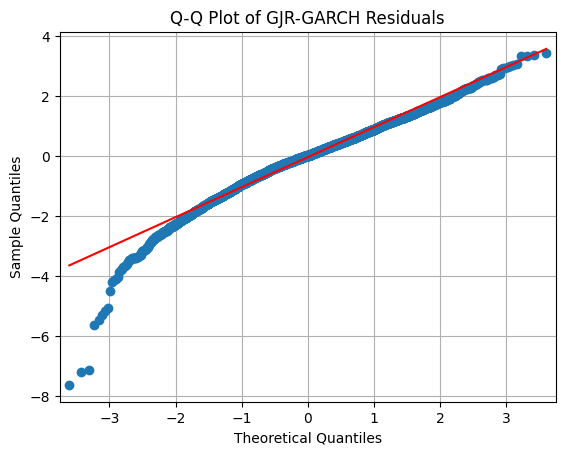

In [ ]:
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
sm.qqplot(clean_resid, line='s')
plt.title('Q-Q Plot of GJR-GARCH Residuals')
plt.grid(True)

qqplot_path = os.path.join(output_dir, 'gjr_garch_qqplot.png')
plt.savefig(qqplot_path)

plt.show()


The Q-Q plot reveals noticeable left-skewness and a heavy left tail, indicating that the model may be underestimating extreme negative returns. To address this, planned improvements include enhancing the mean equation by incorporating autoregressive (AR) terms and adopting a skewed Student’s t-distribution (dist='skewt') to better capture the observed asymmetry and heavy-tailed behavior in the residuals.

# 4. AR(1)-GJR-GARCH(1,1)-Skew-t Model

This model integrates three key components:

- **AR(1) Mean Equation**: Captures autocorrelation in the return series, accounting for short-term momentum or mean-reverting behavior.
- **GJR-GARCH(1,1) Volatility Model**: Allows for asymmetric volatility clustering, where negative shocks can have a stronger impact on future volatility than positive shocks (leverage effect).
- **Skewed Student's t-distribution (skewt)**: Handles heavy tails and skewness in the residuals, providing a more flexible error distribution especially suited for financial time series exhibiting left-skew or fat tails (as seen in the above Q-Q plot).




In [ ]:
gjr_model_skewt = arch_model(
    returns,
    mean='AR',
    lags=1,
    vol='GARCH',
    p=1,
    q=1,
    o=1,
    dist='skewt')
gjr_result_skewt = gjr_model_skewt.fit()
print(gjr_result_skewt.summary())

# Save the summary to a text file
summary_text = gjr_result_skewt.summary().as_text()

summary_path = os.path.join(output_dir, 'ar1_gjr_garch_skewt_model_summary.txt')
with open(summary_path, 'w') as f:
    f.write(summary_text)



Iteration:      1,   Func. Count:     10,   Neg. LLF: 539951.7814717804
Iteration:      2,   Func. Count:     24,   Neg. LLF: 505533.2645215645
Iteration:      3,   Func. Count:     37,   Neg. LLF: 198681.04212532344
Iteration:      4,   Func. Count:     48,   Neg. LLF: 573544.3025076608
Iteration:      5,   Func. Count:     59,   Neg. LLF: 78992.7741427519
Iteration:      6,   Func. Count:     69,   Neg. LLF: 945964.1637964428
Iteration:      7,   Func. Count:     80,   Neg. LLF: 210404.3757972975
Iteration:      8,   Func. Count:     90,   Neg. LLF: 8732.633549044647
Iteration:      9,   Func. Count:    100,   Neg. LLF: 9985.142179732939
Iteration:     10,   Func. Count:    111,   Neg. LLF: 8598.271516240853
Iteration:     11,   Func. Count:    121,   Neg. LLF: 8719.262147025498
Iteration:     12,   Func. Count:    131,   Neg. LLF: 8588.868105044945
Iteration:     13,   Func. Count:    140,   Neg. LLF: 8588.379764434578
Iteration:     14,   Func. Count:    149,   Neg. LLF: 8588.34318

### Summary of AR(1)-GJR-GARCH(1,1)-Skewed t Model Results

- **Mean Model (AR(1))**:
  - The constant term (`Const`) is positive and significant, indicating a small positive average return.
  - The AR(1) coefficient is negative and significant, suggesting some mean-reversion in returns.

- **Volatility Model (GJR-GARCH(1,1))**:
  - `omega` (constant volatility) is positive and significant.
  - `alpha[1]` (reaction to positive shocks) is effectively zero and insignificant.
  - `gamma[1]` (asymmetric effect) is positive and highly significant, confirming that negative shocks increase volatility more than positive shocks.
  - `beta[1]` (persistence of volatility) is very high (~0.88), showing strong volatility clustering.

- **Distribution (Skewed Student’s t)**:
  - `eta` (degrees of freedom) is around 7.57, indicating heavy tails compared to a normal distribution.
  - `lambda` (skewness parameter) is significantly negative, confirming left skewness in the residuals.

- **Model Fit**:
  - Log-Likelihood: -8588.33, AIC: 17192.7, BIC: 17246.8.
  - The R-squared is low (0.006), which is common in financial return models but the significant parameters indicate meaningful dynamics.

---

### Notes for Improvement

- The AR(1) mean structure captures some autocorrelation, but further enhancements could include more lags or nonlinear terms.
- The Q-Q plot of residuals still shows some deviations, especially left skewness and heavy tails.
- Future work could explore more flexible mean equations and alternative distributions, such as the skewed t used here, to better capture the empirical features of the returns.


## Comparing Fit of GJR-GARCH Models with t and Skew-t Distributions

--- AR-t ---
Log-likelihood: -8636.86
AIC: 17287.73
BIC: 17335.10
AR-t Skewness: -0.6571
AR-t Kurtosis: 2.4052
AR-t Sample size: 6423



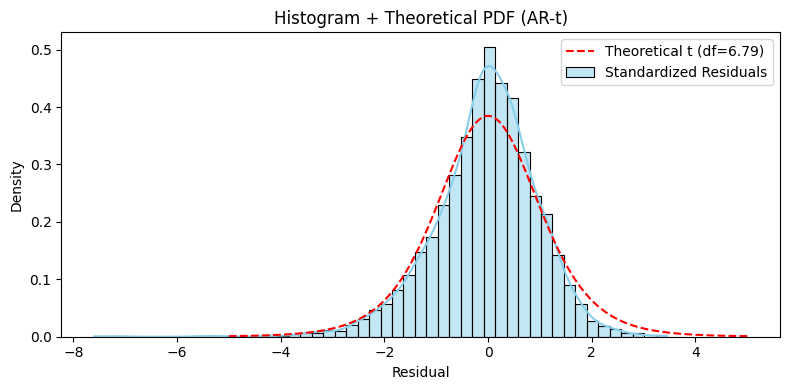

--- AR-skewt ---
Log-likelihood: -8588.33
AIC: 17192.67
BIC: 17246.81
AR-skewt Skewness: -0.6576
AR-skewt Kurtosis: 2.3794
AR-skewt Sample size: 6423



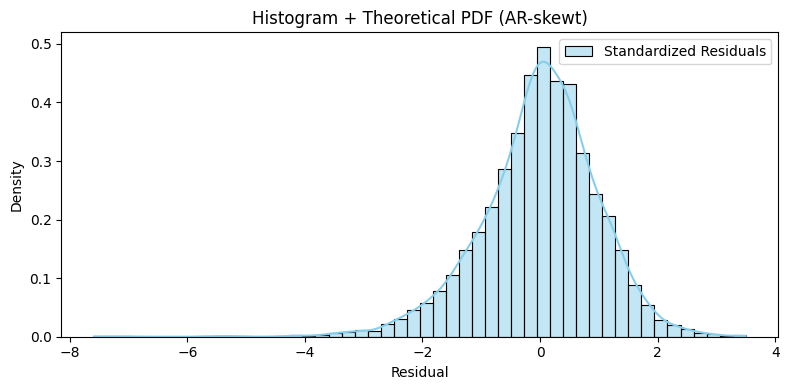

--- Constant-t ---
Log-likelihood: -8643.03
AIC: 17298.06
BIC: 17338.67
Constant-t Skewness: -0.6489
Constant-t Kurtosis: 2.4074
Constant-t Sample size: 6424



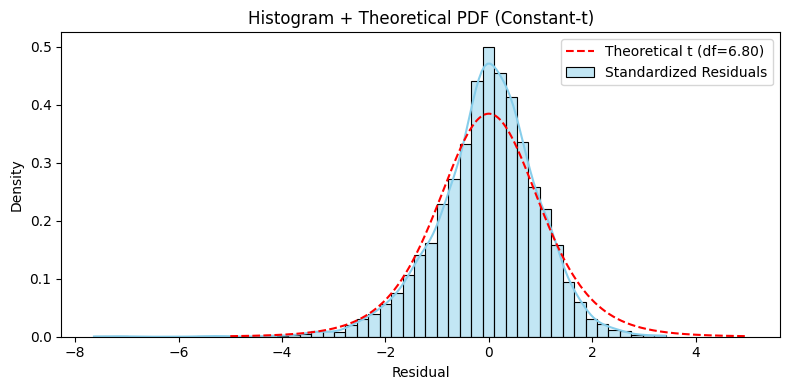

--- Constant-skewt ---
Log-likelihood: -8598.27
AIC: 17210.53
BIC: 17257.91
Constant-skewt Skewness: -0.6481
Constant-skewt Kurtosis: 2.3979
Constant-skewt Sample size: 6424



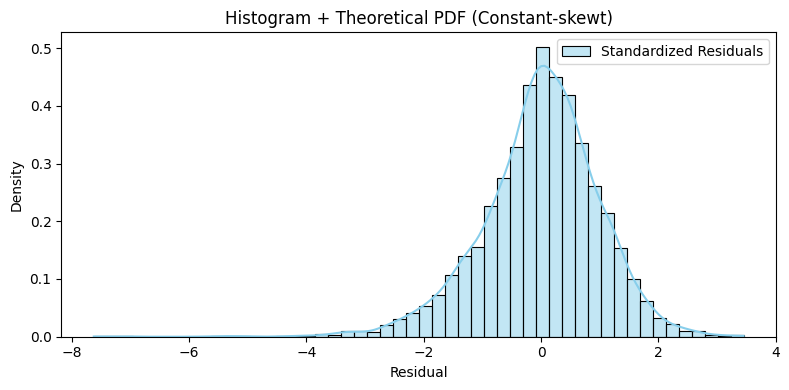


=== Model Comparison Summary ===
             name  loglikelihood           aic           bic
1        AR-skewt   -8588.332944  17192.665888  17246.807013
3  Constant-skewt   -8598.265446  17210.530892  17257.905465
0            AR-t   -8636.864874  17287.729748  17335.103232
2      Constant-t   -8643.030374  17298.060748  17338.667526


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import scipy.stats as stats
import os

# === Output directory ===
output_dir = '/figure'
os.makedirs(output_dir, exist_ok=True)

# === Step 1: Load Data ===
df = pd.read_csv('/data/SPY_Daily_Full_ATR.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')
df['log_return'] = np.log(df['close'] / df['close'].shift(1)) * 100
returns = df['log_return'].dropna()

# === Step 2: Define Utility Functions ===
def clean_array(arr):
    return arr[np.isfinite(arr)]  # Remove NaN and Inf

def calc_skew_kurtosis(residuals, name):
    res_clean = clean_array(residuals)
    skew = stats.skew(res_clean)
    kurt = stats.kurtosis(res_clean)
    print(f"{name} Skewness: {skew:.4f}")
    print(f"{name} Kurtosis: {kurt:.4f}")
    print(f"{name} Sample size: {len(res_clean)}\n")
    return res_clean

def plot_residual_histogram(res_clean, dist_name, params=None, label='model'):
    plt.figure(figsize=(8, 4))
    sns.histplot(res_clean, kde=True, stat='density', bins=50, color='skyblue', label='Standardized Residuals')

    x = np.linspace(-5, 5, 1000)
    if dist_name == 't':
        df_t = params['nu']
        plt.plot(x, stats.t.pdf(x, df=df_t), 'r--', label=f'Theoretical t (df={df_t:.2f})')
    elif dist_name == 'skewt':
        plt.title("Skew-t density not shown (no closed-form PDF in scipy)")

    plt.title(f"Histogram + Theoretical PDF ({label})")
    plt.xlabel('Residual')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()

    # Save plot
    plot_filename = os.path.join(output_dir, f"residual_hist_{label}.png")
    plt.savefig(plot_filename, dpi=300)
    plt.show()

def fit_gjr_model(returns, mean_type='AR', dist='t'):
    model = arch_model(returns, mean=mean_type, lags=1 if mean_type == 'AR' else 0,
                       vol='GARCH', p=1, o=1, q=1, dist=dist)
    result = model.fit(disp="off")
    resid_std = result.resid / result.conditional_volatility
    return result, resid_std

# === Step 3: Fit and Evaluate Four Models ===
models_info = []

for mean_type in ['AR', 'Constant']:
    for dist in ['t', 'skewt']:
        label = f"{mean_type}-{dist}"
        result, resid_std = fit_gjr_model(returns, mean_type=mean_type, dist=dist)
        print(f"--- {label} ---")
        print(f"Log-likelihood: {result.loglikelihood:.2f}")
        print(f"AIC: {result.aic:.2f}")
        print(f"BIC: {result.bic:.2f}")
        res_clean = calc_skew_kurtosis(resid_std, label)
        plot_residual_histogram(res_clean, dist_name=dist, params=result.params, label=label)
        models_info.append({
            'name': label,
            'loglikelihood': result.loglikelihood,
            'aic': result.aic,
            'bic': result.bic
        })

# === Step 4: Summarize and Save Model Comparison ===
summary_df = pd.DataFrame(models_info)
print("\n=== Model Comparison Summary ===")
print(summary_df.sort_values('aic'))

summary_csv_path = os.path.join(output_dir, 'ar_constant_t_skewt_Model_Comparison_Summary.csv')
summary_df.to_csv(summary_csv_path, index=False)


### Summary of AR(1)-GJR-GARCH Model with Skew-t Distribution

This model consists of three key components:

- **AR(1)** mean structure capturing short-term autocorrelation in returns.
- **GJR-GARCH(1,1)** volatility model addressing volatility clustering and asymmetric volatility effects.
- **Skewed Student’s t-distribution (skewt)** to account for skewness and heavy tails in return residuals.

---

### Model Fit and Comparison Summary

I fitted four variants of the GJR-GARCH model to the same dataset:

| Model           | Log-Likelihood | AIC       | BIC       |
|-----------------|----------------|-----------|-----------|
| AR-skewt        | -8588.33       | 17192.67  | 17246.81  |
| Constant-skewt  | -8598.27       | 17210.53  | 17257.91  |
| AR-t            | -8636.86       | 17287.73  | 17335.10  |
| Constant-t      | -8643.03       | 17298.06  | 17338.67  |

**Key observations:**

- The **AR(1)-GJR-GARCH with skew-t distribution** (AR-skewt) achieves the best fit based on lowest AIC and BIC values.
- Including the AR(1) mean structure improves fit compared to a constant mean.
- The skew-t distribution outperforms the symmetric t-distribution by better capturing asymmetry and heavy tails in residuals.
- Residual diagnostics show remaining slight skewness and kurtosis, indicating room for further improvement.

---

**Conclusion**

The AR(1)-GJR-GARCH(1,1) model with skewed Student’s t-distribution currently provides the best balance of complexity and fit for this data, effectively capturing volatility asymmetry and tail behavior. Future work should explore richer mean structures and alternative distributions to further enhance model accuracy.


# 6. Model Diagnostics: AR(1)-GJR-GARCH with Skew-t Distribution
This section performs model diagnostics on the AR(1)-GJR-GARCH model with a skewed t-distribution. The diagnostics include:

- Ljung-Box Test – To check if standardized residuals are white noise.

- Skewness, Kurtosis, Jarque-Bera Normality Test – To examine residual normality.

- ACF/PACF Plots – To assess volatility clustering and remaining autocorrelations

## Step 1: Ljung-Box Test (on standardized residuals)


Ljung-Box Test Results (Standardized Residuals):
      lb_stat  lb_pvalue
1    1.812491   0.178210
2    3.934172   0.139864
3    6.125017   0.105684
4    6.162644   0.187327
5    9.047100   0.107200
6   12.334915   0.054901
7   12.588035   0.082805
8   12.826990   0.117943
9   12.862763   0.168915
10  12.886254   0.230101
11  13.580225   0.257097
12  14.083732   0.295393
13  14.324898   0.351368
14  15.075815   0.372992
15  19.608935   0.187453
16  19.704251   0.233837
17  20.035162   0.272435
18  20.210327   0.321104
19  20.651313   0.356383
20  20.876900   0.404410


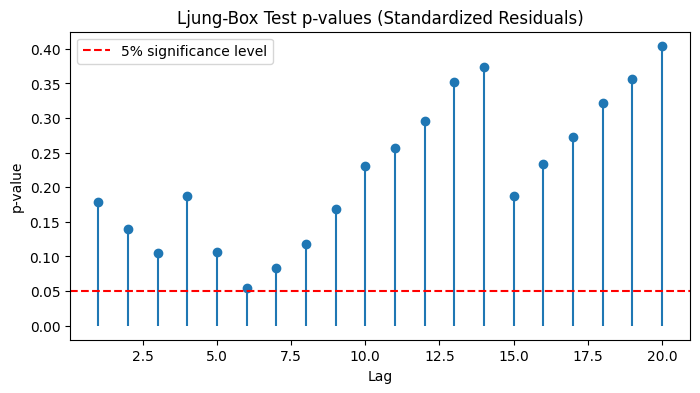

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

# Step 1: Get standardized residuals
standardized_resid = gjr_result_skewt.std_resid

# Step 2: Drop NaN values
resid_clean = standardized_resid.dropna()

# Step 3: Ljung-Box test
ljung_box_result = acorr_ljungbox(resid_clean, lags=20, return_df=True)

# Step 4: Print results
print("Ljung-Box Test Results (Standardized Residuals):")
print(ljung_box_result)

# Step 5: Plot p-values
plt.figure(figsize=(8, 4))
plt.stem(ljung_box_result.index, ljung_box_result['lb_pvalue'], basefmt=" ")
plt.axhline(y=0.05, color='red', linestyle='--', label='5% significance level')
plt.title('Ljung-Box Test p-values (Standardized Residuals)')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.legend()

# Step 6: Save the plot
output_dir = '/figure'
plt.savefig(f"{output_dir}/ljungbox_pvalues.png", dpi=300, bbox_inches='tight')
plt.show()


**Interpretation of Ljung-Box Test Results:**

The Ljung-Box test is used to assess whether the residuals of a time series model are independently distributed (i.e., exhibit no autocorrelation).

- Null Hypothesis (H₀): The residuals are white noise (no autocorrelation).

- Alternative Hypothesis (H₁): The residuals are autocorrelated.

In this case, all p-values are greater than the 5% significance level, indicating that we fail to reject the null hypothesis at all lags.
This suggests that the standardized residuals behave like white noise, with no significant autocorrelation present.

**Conclusion**:

The AR(1)-GJR-GARCH model with a skew-t distribution appears to fit the data well, having effectively captured the conditional volatility and structure of the time series.

## Step 2: Normality Tests (Skewness, Kurtosis, Jarque-Bera)

These tests are used to check if the standardized residuals from the model follow a normal distribution:

- Skewness measures the asymmetry of the distribution. A value close to 0 indicates symmetry.

- Kurtosis measures the "tailedness" of the distribution. For a normal distribution, the kurtosis is 3.

- Jarque-Bera test is a formal statistical test combining skewness and kurtosis to test for normality.

  - Null hypothesis (H₀): Residuals are normally distributed

  - Alternative hypothesis (H₁): Residuals are not normally distributed

In [ ]:
from scipy.stats import skew, kurtosis, jarque_bera

# Assume standardized_resid is your standardized residual series (numpy array or pandas Series)
std_resid = standardized_resid.dropna()

# Calculate skewness and kurtosis
resid_skewness = skew(std_resid)
resid_kurtosis = kurtosis(std_resid, fisher=False)  # fisher=False gives Pearson's kurtosis (normal=3)

# Perform Jarque-Bera test
jb_stat, jb_pvalue = jarque_bera(std_resid)

print(f"Skewness: {resid_skewness:.4f}")
print(f"Kurtosis: {resid_kurtosis:.4f}")
print(f"Jarque-Bera Test Statistic: {jb_stat:.4f}")
print(f"Jarque-Bera Test p-value: {jb_pvalue:.4f}")

# Interpretation example
if jb_pvalue < 0.05:
    print("Reject H0: Residuals are NOT normally distributed.")
else:
    print("Fail to reject H0: Residuals are normally distributed.")


Skewness: -0.6576
Kurtosis: 5.3794
Jarque-Bera Test Statistic: 1978.0730
Jarque-Bera Test p-value: 0.0000
Reject H0: Residuals are NOT normally distributed.


Skewness of -0.6576 indicates a left-skewed distribution, meaning the residuals have a longer tail on the negative side and are asymmetric.
Kurtosis of 5.3794, which is greater than 3 (the kurtosis of a normal distribution), suggests heavy tails and a peaked distribution with more extreme values than normal.
The Jarque-Bera test statistic of 1978.0730 with a p-value near 0.0000 strongly rejects the null hypothesis of normality.

**Null hypothesis (H0)**: Residuals follow a normal distribution.

**Conclusion:**

- Residuals are not normally distributed, exhibiting skewness and heavy tails.

- This is common in financial time series modeling, especially with volatility clustering as in GARCH models. Residuals often deviate from normality, showing skewness and leptokurtosis. The use of a skew-t distribution in the GARCH model is appropriate to better capture these non-normal characteristics.

- Although residuals are not normal, this does not necessarily indicate poor model fit but highlights that models assuming normality may fail to fully capture the data’s behavior, thus justifying the use of heavy-tailed distributions like skew-t.

## Step 3: ACF & PACF plots for squared standardized residuals (to check volatility clustering)

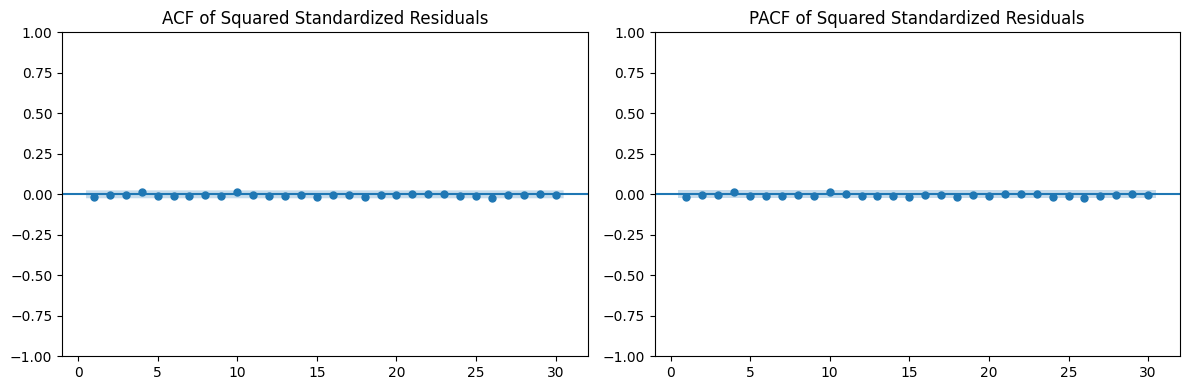

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Step 3: ACF & PACF plots for squared standardized residuals (to check volatility clustering)
resid_squared = resid_clean ** 2

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(resid_squared, lags=30, zero=False, ax=axs[0])
axs[0].set_title("ACF of Squared Standardized Residuals")

plot_pacf(resid_squared, lags=30, zero=False, ax=axs[1])
axs[1].set_title("PACF of Squared Standardized Residuals")

plt.tight_layout()

# Save figure to desired path
output_dir = '/figure'
plt.savefig(f"{output_dir}/acf_pacf_squared_residuals.png", dpi=300)

plt.show()


The ACF and PACF plots show all points fluctuating closely around the zero line with no significant spikes. This indicates a lack of strong autocorrelation or partial autocorrelation in the squared standardized residuals. In other words, there is no clear evidence of volatility clustering remaining in the model residuals, suggesting that the GARCH model has effectively captured the conditional heteroskedasticity in the data.

In [ ]:
# Ljung-Box test on squared residuals to formally test for ARCH effects
lb_test_squared = acorr_ljungbox(resid_squared, lags=[10, 15, 20], return_df=True)
print("Ljung-Box Test Results (Squared Residuals):")
print(lb_test_squared)


Ljung-Box Test Results (Squared Residuals):
      lb_stat  lb_pvalue
10   8.447005   0.585260
15  12.598574   0.633273
20  15.268069   0.760869


Explanation of the Ljung-Box Test Results (Squared Residuals):
The Ljung-Box test results for the squared residuals at lags 10, 15, and 20 show p-values all greater than 0.05 (0.585, 0.633, 0.761). This means that the null hypothesis (no autocorrelation) cannot be rejected at these lag values. In other words, there is no significant evidence of remaining autocorrelation or volatility clustering in the squared residuals, indicating that the GARCH model has successfully captured the time-varying volatility.

## Batch Estimation and Comparison of GARCH Family Models with t and Skew-t Distributions

In [ ]:
import numpy as np
import pandas as pd
from arch import arch_model

# === Step 1: Load data ===
df = pd.read_csv('/data/SPY_Daily_Full_ATR.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')
df['log_return'] = np.log(df['close'] / df['close'].shift(1)) * 100
returns = df['log_return'].dropna()

# === Step 2: Define list of model configurations ===
model_configs = [
    # GARCH(1,1)
    {'name': 'GARCH(1,1)-t-Constant', 'mean': 'Constant', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 't'},
    {'name': 'GARCH(1,1)-t-AR1', 'mean': 'AR', 'lags': 1, 'vol': 'GARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 't'},
    {'name': 'GARCH(1,1)-skewt-Constant', 'mean': 'Constant', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 'skewt'},
    {'name': 'GARCH(1,1)-skewt-AR1', 'mean': 'AR', 'lags': 1, 'vol': 'GARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 'skewt'},

    # EGARCH(1,1)
    {'name': 'EGARCH(1,1)-t-Constant', 'mean': 'Constant', 'lags': 0, 'vol': 'EGARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 't'},
    {'name': 'EGARCH(1,1)-t-AR1', 'mean': 'AR', 'lags': 1, 'vol': 'EGARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 't'},
    {'name': 'EGARCH(1,1)-skewt-Constant', 'mean': 'Constant', 'lags': 0, 'vol': 'EGARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 'skewt'},
    {'name': 'EGARCH(1,1)-skewt-AR1', 'mean': 'AR', 'lags': 1, 'vol': 'EGARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 'skewt'},

    # GJR-GARCH(1,1)
    {'name': 'GJR-GARCH(1,1)-t-Constant', 'mean': 'Constant', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 1, 'q': 1, 'dist': 't'},
    {'name': 'GJR-GARCH(1,1)-t-AR1', 'mean': 'AR', 'lags': 1, 'vol': 'GARCH', 'p': 1, 'o': 1, 'q': 1, 'dist': 't'},
    {'name': 'GJR-GARCH(1,1)-skewt-Constant', 'mean': 'Constant', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 1, 'q': 1, 'dist': 'skewt'},
    {'name': 'GJR-GARCH(1,1)-skewt-AR1', 'mean': 'AR', 'lags': 1, 'vol': 'GARCH', 'p': 1, 'o': 1, 'q': 1, 'dist': 'skewt'},
]

# === Step 3: Run all models and save results ===
results = []

for cfg in model_configs:
    print(f"Fitting model: {cfg['name']}")
    model = arch_model(returns, mean=cfg['mean'], lags=cfg['lags'], vol=cfg['vol'], p=cfg['p'], o=cfg['o'], q=cfg['q'], dist=cfg['dist'])
    res = model.fit(disp='off')
    results.append({
        'Model': cfg['name'],
        'Log-Likelihood': res.loglikelihood,
        'AIC': res.aic,
        'BIC': res.bic
    })

# === Step 4: Aggregate results into a DataFrame and print ===
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='AIC').reset_index(drop=True)

print("\n=== Model Comparison Summary ===")
print(df_results)


Fitting model: GARCH(1,1)-t-Constant
Fitting model: GARCH(1,1)-t-AR1
Fitting model: GARCH(1,1)-skewt-Constant
Fitting model: GARCH(1,1)-skewt-AR1
Fitting model: EGARCH(1,1)-t-Constant
Fitting model: EGARCH(1,1)-t-AR1
Fitting model: EGARCH(1,1)-skewt-Constant
Fitting model: EGARCH(1,1)-skewt-AR1
Fitting model: GJR-GARCH(1,1)-t-Constant
Fitting model: GJR-GARCH(1,1)-t-AR1
Fitting model: GJR-GARCH(1,1)-skewt-Constant
Fitting model: GJR-GARCH(1,1)-skewt-AR1

=== Model Comparison Summary ===
                            Model  Log-Likelihood           AIC           BIC
0        GJR-GARCH(1,1)-skewt-AR1    -8588.332944  17192.665888  17246.807013
1   GJR-GARCH(1,1)-skewt-Constant    -8598.265446  17210.530892  17257.905465
2            GJR-GARCH(1,1)-t-AR1    -8636.864874  17287.729748  17335.103232
3       GJR-GARCH(1,1)-t-Constant    -8643.030374  17298.060748  17338.667526
4            GARCH(1,1)-skewt-AR1    -8709.947060  17433.894121  17481.267605
5           EGARCH(1,1)-skewt-AR1    -87

In [ ]:
import os
import matplotlib.pyplot as plt

# === Step 5: Save results table and plot ===
output_dir = '/figure'
os.makedirs(output_dir, exist_ok=True)

# Save the results DataFrame as CSV
df_results.to_csv(os.path.join(output_dir, '12model_comparison_results.csv'), index=False)


### Summary of Model Comparison for Volatility Modeling

Twelve variants of volatility models to daily log-returns data were fitted, including GARCH(1,1), EGARCH(1,1), and GJR-GARCH(1,1) models. Each model was estimated with two residual error distributions (Student’s t and skewed Student’s t) and two mean specifications (constant mean and AR(1) mean).

The model comparison, based on AIC and BIC criteria, indicates that the GJR-GARCH(1,1) model with a skewed Student’s t-distribution and AR(1) mean structure achieves the best fit to the data, evidenced by the lowest AIC (17192.67) and BIC (17246.81) values. This model outperforms all standard GARCH and EGARCH specifications, highlighting the importance of incorporating both asymmetric volatility effects (captured by GJR) and skewness in the error distribution.

Models with skewed t-distributions generally perform better than their symmetric t counterparts, suggesting that the returns exhibit asymmetry and heavy tails. Moreover, including an autoregressive mean term (AR1) typically improves model fit compared to a constant mean.

In summary, these results support the use of the GJR-GARCH(1,1) skew-t AR(1) model as the most suitable choice for capturing the conditional volatility dynamics and distributional characteristics of the SPY daily returns in this dataset.



# 7. Risk Management Applications

In [ ]:
# The following code performs volatility forecasting and Value at Risk (VaR) testing
# for a fitted GJR-GARCH(1,1) model with an AR(1) mean equation and skewed Student's t distribution.

# Explanation:
# cond_vol: Extracted conditional volatility forecasts representing the predicted daily standard deviation of returns.
# t_critical: The 1% quantile of the Student's t distribution (typically negative), used for VaR calculation.
# VaR(99%): The estimated maximum daily loss at the 99% confidence level (expressed as a negative return percentage).

import pandas as pd
import numpy as np
from arch import arch_model
from scipy.stats import t

# === Step 1: Load data ===
df = pd.read_csv('/data/SPY_Daily_Full_ATR.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')
df['log_return'] = np.log(df['close'] / df['close'].shift(1)) * 100
returns = df['log_return'].dropna()

# === Step 2: Fit the best-fit model ===
model = arch_model(
    returns,
    mean='AR',
    lags=1,
    vol='GARCH',
    p=1,
    q=1,
    o=1,
    dist='skewt')

res = model.fit(update_freq=5, disp="off")
print(res.summary())

# === Step 3: Volatility forecasting ===
forecast_horizon = 10
forecast = res.forecast(horizon=forecast_horizon)
cond_vol = forecast.variance.iloc[-1] ** 0.5

# === Step 4: VaR calculation at 99% confidence level ===
df_t = res.params['eta']  # Degrees of freedom for the t-distribution
alpha = 0.01  # Significance level (1 - confidence level)
t_critical = t.ppf(alpha, df_t)  # Critical t value

VaR_99 = t_critical * cond_vol.values  # Daily VaR estimates (same units as log returns, %)

# Create VaR results DataFrame
VaR_df = pd.DataFrame({
    'Forecast_Day': np.arange(1, forecast_horizon + 1),
    'VaR(99%)': VaR_99
})

print("\n=== 10-day ahead VaR forecasts at 99% confidence level ===")
print(VaR_df)


                               AR - GJR-GARCH Model Results                              
Dep. Variable:                        log_return   R-squared:                       0.006
Mean Model:                                   AR   Adj. R-squared:                  0.006
Vol Model:                             GJR-GARCH   Log-Likelihood:               -8588.33
Distribution:      Standardized Skew Student's t   AIC:                           17192.7
Method:                       Maximum Likelihood   BIC:                           17246.8
                                                   No. Observations:                 6423
Date:                           Tue, May 20 2025   Df Residuals:                     6421
Time:                                   20:52:11   Df Model:                            2
                                    Mean Model                                   
                    coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------

## 7.1. VaR Estimates Across Different Confidence Levels: 95% and 99%

In [ ]:
from scipy.stats import t
import pandas as pd
import numpy as np

# Degrees of freedom of the fitted Student's t-distribution
df_t = res.params['eta']

# Confidence levels for VaR calculation (95% and 99%)
alphas = [0.05, 0.01]  # corresponding to 95% and 99% confidence

# Dictionary to store VaR values at different confidence levels
var_levels = {}

# Calculate VaR for each confidence level
for alpha in alphas:
    t_critical = t.ppf(alpha, df_t)  # Left-tail quantile for Student's t
    var = t_critical * cond_vol.values.flatten()  # Scale by forecasted volatility
    var_levels[f"VaR({100*(1-alpha):.0f}%)"] = var

# Create DataFrame for VaR forecasts at multiple confidence levels
VaR_multi_df = pd.DataFrame({
    'Forecast_Day': np.arange(1, forecast_horizon + 1),
    'VaR(95%)': var_levels['VaR(95%)'],
    'VaR(99%)': var_levels['VaR(99%)'],
})

print("\n=== VaR Forecasts at Multiple Confidence Levels (in %) ===")
print(VaR_multi_df)



=== VaR Forecasts at Multiple Confidence Levels (in %) ===
   Forecast_Day  VaR(95%)  VaR(99%)
0             1 -1.827165 -2.863673
1             2 -1.834773 -2.875597
2             3 -1.839813 -2.883496
3             4 -1.844757 -2.891244
4             5 -1.849614 -2.898856
5             6 -1.854385 -2.906334
6             7 -1.859073 -2.913681
7             8 -1.863678 -2.920899
8             9 -1.868204 -2.927992
9            10 -1.872650 -2.934961


### Summary of VaR Forecasts at Multiple Confidence Levels

The table presents the 10-day ahead daily VaR forecasts at the 95% and 99% confidence levels (expressed in %).
For instance, on Day 1, the VaR(95%) is approximately -1.83%, and the VaR(99%) is about -2.86%. This means there is a 5% chance that the loss will exceed 1.83% on Day 1, and a 1% chance that the loss will exceed 2.86% on the same day.

At the 99% confidence level, the absolute VaR values are consistently larger than at the 95% level, reflecting a more conservative risk estimate accounting for extreme market events.
As the forecast horizon increases from Day 1 to Day 10, the VaR values show a gradual increase in magnitude, with VaR(95%) moving from about -1.83% to -1.87%, and VaR(99%) from approximately -2.86% to -2.93%, indicating a slight accumulation of risk over the forecast period.

These results allow investors and risk managers to choose appropriate risk thresholds based on their tolerance, where the 99% VaR offers a stricter control benchmark.

## 7.2. Expected Shortfall (ES) Calculation (Based on t-Distribution)

In financial risk management, **Expected Shortfall (ES)** — also known as **Conditional Value at Risk (CVaR)** — is the **average loss in the tail beyond the VaR threshold** at a given confidence level α. It better captures the risk of extreme losses compared to VaR and is considered a more **robust and conservative** risk measure.

---

#### Formula (Under t-Distribution Assumption)

Assuming returns follow a Student's t-distribution, the Expected Shortfall at confidence level α is calculated as:

$$
\text{ES}_\alpha = -\sigma \cdot \frac{f_t(t_\alpha; \nu)}{\alpha} \cdot \frac{\nu + t_\alpha^2}{\nu - 1}
$$

Where:

- **α**: Tail probability (e.g., 0.01 for 99% confidence level)
- **ν**: Degrees of freedom of the t-distribution
- **σ**: Conditional volatility (from GARCH forecasts)
- **t<sub>α</sub>**: Quantile of the t-distribution at α (left tail)
- **f<sub>t</sub>(t<sub>α</sub>; ν)**: PDF of the t-distribution evaluated at t<sub>α</sub>

This formula is appropriate when the return distribution is modeled as a Student's t-distribution, as often done in GARCH-type models.

In [ ]:
from scipy.stats import t

def compute_ES(alpha, df_t, sigma):
    t_alpha = t.ppf(alpha, df_t)
    pdf_val = t.pdf(t_alpha, df_t)
    multiplier = ((df_t + t_alpha**2) / (df_t - 1)) * (pdf_val / alpha)
    return -multiplier * sigma

# Compute ES for both 95% and 99% confidence levels
es_95 = compute_ES(0.05, df_t, cond_vol.values)
es_99 = compute_ES(0.01, df_t, cond_vol.values)

# Construct results DataFrame
ES_df = pd.DataFrame({
    'Forecast_Day': np.arange(1, forecast_horizon + 1),
    'ES(95%)': es_95,
    'ES(99%)': es_99,
})

print("\n=== Expected Shortfall (ES) Forecasts (in %) ===")
print(ES_df)



=== Expected Shortfall (ES) Forecasts (in %) ===
   Forecast_Day   ES(95%)   ES(99%)
0             1 -2.482659 -3.569935
1             2 -2.492997 -3.584800
2             3 -2.499845 -3.594647
3             4 -2.506562 -3.604307
4             5 -2.513161 -3.613796
5             6 -2.519644 -3.623118
6             7 -2.526014 -3.632277
7             8 -2.532272 -3.641276
8             9 -2.538420 -3.650117
9            10 -2.544462 -3.658805


### Summary of Expected Shortfall (ES) Forecasts (in %)

The table shows 10-day forecasts of Expected Shortfall (ES) at 95% and 99% confidence levels.

- **Day 1**:  
  - **ES(95%)** = -2.48%  
  - **ES(99%)** = -3.57%

- Over time, both ES values **gradually increase in magnitude**, reflecting a slight rise in tail risk:  
- **Day 10**: ES(95%) = -2.54%, ES(99%) = -3.66%

- **ES(99%) is more conservative** than ES(95%), as it accounts for more extreme loss scenarios.

> ES provides a more robust risk estimate than VaR, especially under heavy-tailed distributions.


# 8. VaR Backtesting (Ex-Post Evaluation)

This section performs backtesting of the 99% VaR forecast using:

- **Kupiec Proportion of Failures Test**
- **Simple Violation Count**

In [ ]:
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import t
import numpy as np

# Define backtesting window (e.g., last 250 days)
backtest_horizon = 250
actual_returns = returns[-backtest_horizon:]

# Rolling VaR forecasts using historical data
rolling_model = arch_model(returns, mean='AR', lags=1, vol='GARCH', p=1, o=1, q=1, dist='t')
rolling_forecasts = []

for i in range(len(returns) - backtest_horizon, len(returns)):
    r_train = returns[:i]
    m = rolling_model.fit(disp='off')
    f = m.forecast(horizon=1)
    sigma_t = np.sqrt(f.variance.iloc[-1].values[0])
    df_t = m.params['nu']
    t_critical_99 = t.ppf(0.01, df_t)
    VaR_99 = t_critical_99 * sigma_t
    rolling_forecasts.append(VaR_99)

# Compare actual returns vs VaR
VaR_99_series = np.array(rolling_forecasts)
actuals = actual_returns.values
violations = actuals < VaR_99_series

# Kupiec Test (Proportion of Failures)
n_viol = violations.sum()
n_total = len(violations)
expected_rate = 0.01

stat, pval = proportions_ztest(count=n_viol, nobs=n_total, value=expected_rate, alternative='smaller')

print(f"\n=== Backtesting Results (99% VaR) ===")
print(f"Total observations: {n_total}")
print(f"Actual violations: {n_viol}")
print(f"Expected violations: {expected_rate * n_total:.1f}")
print(f"Kupiec Test p-value: {pval:.4f} -> {'Passed' if pval > 0.05 else 'Rejected'}")



=== Backtesting Results (99% VaR) ===
Total observations: 250
Actual violations: 5
Expected violations: 2.5
Kupiec Test p-value: 0.8706 -> Passed


# Visualization

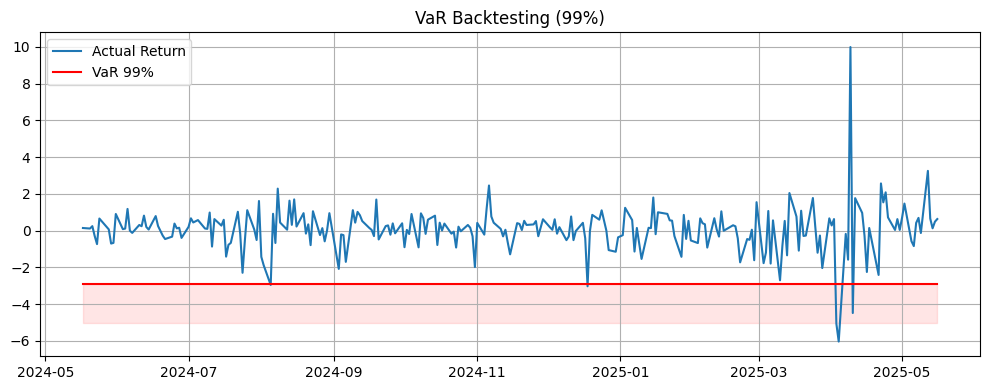

In [ ]:
# Visualization
plt.figure(figsize=(10,4))
plt.plot(actual_returns.index, actuals, label='Actual Return')
plt.plot(actual_returns.index, VaR_99_series, label='VaR 99%', color='red')
plt.fill_between(actual_returns.index, VaR_99_series, -5, color='red', alpha=0.1)
plt.title('VaR Backtesting (99%)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure
output_dir = '/figure'
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist
plt.savefig(f'{output_dir}/VaR_backtesting_99.png', dpi=300, bbox_inches='tight')
plt.show()

### Backtesting Summary (99% VaR)

- **Total Observations**: 250  
- **Actual Violations**: 5  
- **Expected Violations** (at 1% level): 2.5  
- **Kupiec Test p-value**: 0.8706 → **Passed**

#### 📈 Visual Insights:

- **VaR Curve (Red Line):** Dynamically reflects the 99% VaR threshold and successfully covers the vast majority of actual returns (blue line), demonstrating good coverage.

- **Tail Risk Capture:** The 5 observed breaches show that the model is **sensitive to tail events**, yet **no extreme outliers** (e.g., returns far below the VaR) were recorded. This indicates the model provides a **realistic and measured estimation** of tail risk without overreacting.

- **Violation Distribution:** The breaches are **spread across the testing period**, not clustered within any particular window. This suggests the model does **not exhibit time-varying bias** such as volatility clustering or regime shifts that would cause a spike in consecutive violations.

---

✅ **Conclusion**: The VaR model demonstrates **strong performance** as a risk forecasting tool at the 99% confidence level. Its forecasts are stable, violations are within acceptable statistical limits, and it effectively captures downside risk without exaggerating tail events. Therefore, it is well-suited for practical use in **risk management and regulatory reporting**.
